In [3]:
!pip3 install yfinance

     |████████████████████████████████| 6.4 MB 7.6 MB/s 
     |████████████████████████████████| 63 kB 843 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np

Preprocessing

In [6]:
senti = pd.read_csv('Sentiment_Predicted.csv',index_col=0)
senti_old = pd.read_csv('Labelled_old_data.csv',index_col=0)
senti_old=senti_old[senti_old["text"].str.contains("RT @")==False]
senti_old.drop(columns=['id'],inplace=True)
senti = senti[senti['like']!='like']
senti['predicted_label']-=1
senti_old['predicted_label']-=1

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [7]:
senti['like'] = pd.to_numeric(senti['like'])
senti['rt'] = pd.to_numeric(senti['rt'])
senti['vote'] = senti['like']+senti['rt']
senti['weight'] = senti['vote'].apply(lambda x:np.log10(x)) #Weight formula

In [8]:
senti['average_sent'] = senti['weight']*senti['predicted_label']
senti['date'] = pd.to_datetime(senti['date'])
senti_final = senti.groupby('date').sum()

In [86]:
spy = yf.Ticker('SPY')
df = spy.history(start='2020-04-09',end='2022-04-24')
df['change'] = np.sign((df['Close'] - df['Open'])/df['Open']*100)

Date offset

In [23]:
df['pre'] = df.index-pd.tseries.offsets.BDay(0)

In [55]:
merged = pd.merge(df,senti_final,left_on='pre',right_index=True)

In [46]:
merged.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,change,pre,like,rt,predicted_label,vote,weight,average_sent
Date,,,,,,,,,,,,,,,
2022-02-15,442.355790,444.897880,441.807475,444.718445,88482700,0.0,0,0.534107,2022-02-11,12910,3465,72,16375,599.903416,69.663210
2022-02-16,442.555144,446.672358,440.571317,445.216888,84863600,0.0,0,0.601449,2022-02-14,15280,8354,81,23634,664.883094,96.118478
2022-02-17,441.847347,445.186978,435.068419,435.706421,102259100,0.0,0,-1.389830,2022-02-15,12490,3545,137,16035,620.503357,106.136274
2022-02-18,435.975568,437.301466,430.482653,432.885193,132642900,0.0,0,-0.708841,2022-02-16,8805,3389,138,12194,544.937546,125.370486
2022-02-22,430.552446,434.151251,424.541092,428.239624,124391800,0.0,0,-0.537175,2022-02-18,17529,4336,85,21865,557.639866,65.093769


In [30]:
merged.corr()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,change,like,rt,predicted_label,vote,weight,average_sent
Open,1.000000,0.966724,0.959787,0.866025,-0.597150,-0.010664,NaN,-0.280732,-0.263889,-0.081339,0.413271,-0.242071,-0.452281,0.441632
High,0.966724,1.000000,0.973495,0.940541,-0.549193,0.035811,NaN,-0.070852,-0.257626,-0.121711,0.475933,-0.249122,-0.432587,0.494803
Low,0.959787,0.973495,1.000000,0.958788,-0.663601,0.032021,NaN,-0.026472,-0.303321,-0.112927,0.540499,-0.284121,-0.499554,0.554609
Close,0.866025,0.940541,0.958788,1.000000,-0.581498,0.079464,NaN,0.236540,-0.286950,-0.143558,0.590245,-0.279895,-0.470051,0.600072
Volume,-0.597150,-0.549193,-0.663601,-0.581498,1.000000,0.010098,NaN,0.056855,0.473846,0.155952,-0.553948,0.437663,0.486565,-0.543323
Dividends,-0.010664,0.035811,0.032021,0.079464,0.010098,1.000000,NaN,0.169562,-0.040703,-0.131060,0.085204,-0.073186,-0.267474,0.086265
Stock Splits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
change,-0.280732,-0.070852,-0.026472,0.236540,0.056855,0.169562,NaN,1.000000,-0.030778,-0.115403,0.321795,-0.060271,-0.014905,0.285623
like,-0.263889,-0.257626,-0.303321,-0.286950,0.473846,-0.040703,NaN,-0.030778,1.000000,0.460111,-0.395992,0.963262,0.335534,-0.319974
rt,-0.081339,-0.121711,-0.112927,-0.143558,0.155952,-0.131060,NaN,-0.115403,0.460111,1.000000,-0.360481,0.681653,0.208859,-0.254541


Training & Plotting

In [56]:
from matplotlib import pyplot as plt
print('Correlation:',np.correlate(merged['average_sent']/merged['weight'],merged['change']))
x = np.array(merged['average_sent']/merged['weight'])
y = np.array(merged['change'])

Correlation: [0.53439082]


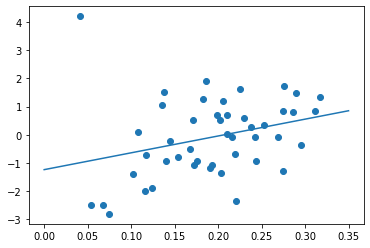

In [57]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x.reshape(-1,1),y.reshape(-1,1))
ls = np.linspace(0,0.35,100).reshape(-1,1)
pred = lr.predict(ls)
plt.plot(ls,pred)
plt.scatter(merged['average_sent']/merged['weight'],merged['change']);

In [41]:
init = 1
cor = 0
for d in merged.index:
    if lr.predict(np.array(merged['average_sent'][d]/merged['weight'][d]).reshape(-1,1)) > 0:
        init *= (1+merged['change'][d]/100)
        if merged['change'][d]>0:
            cor+=1
    else:
        init *= (1-merged['change'][d]/100)
        if merged['change'][d]<0:
            cor+=1
print('Final account value:',init)

Final account value: 1.0489073931532953


In [42]:
accuracy = cor/len(merged)
accuracy

0.5333333333333333

In [43]:
init = 1
for d in merged.index:
    init *= (1+merged['change'][d]/100)
init

0.9968172203483538

Experiment

In [16]:
senti

,text,like,rt,date,predicted_label,vote,weight,average_sent
0,$BBIG - When you see more and more institution...,40,3,2022-02-11,1,43,1.633468,1.633468
1,#Stocks With #PE #Ratio Below 21\n\n- SAIL - 3...,688,102,2022-02-11,-1,790,2.897627,-2.897627
2,How To Turn 1k Into 100k In 15 Trades Or Less ...,2,1,2022-02-11,0,3,0.477121,0.000000
3,HCC (M) Chart.\nStocks shows a classic example...,30,10,2022-02-11,1,40,1.602060,1.602060
4,#pton #Peloton Inventory/Assets Ratio. Low de...,5,1,2022-02-11,-1,6,0.778151,-0.778151
...,...,...,...,...,...,...,...,...
48993,📈 Global edible oil markets simmer after shock...,3,2,2022-04-23,-1,5,0.698970,-0.698970
48994,#TIMETECHNO - Chart Analysis\n\nExpect Positiv...,2,1,2022-04-23,1,3,0.477121,0.477121
48995,Utkrisht Weekend Chart.\n#onmobile on (M) char...,7,1,2022-04-23,1,8,0.903090,0.903090
48996,📈 Analysis-Dollar's rally may be nearing 'tipp...,2,2,2022-04-23,1,4,0.602060,0.602060


In [89]:
adj_st=senti.copy()
adj_st['pos_rt']=adj_st[adj_st['predicted_label']==1]['rt']#np.abs(adj_st['rt'])*adj_st['predicted_label']
adj_st['neg_rt']=adj_st[adj_st['predicted_label']==-1]['rt']
adj_st['pos_like']=adj_st[adj_st['predicted_label']==1]['like']#np.abs(adj_st['like'])*adj_st['predicted_label']
adj_st['neg_like']=adj_st[adj_st['predicted_label']==-1]['like']
adj_st['pos_senti']=adj_st[adj_st['predicted_label']==1]['predicted_label']
adj_st['neg_senti']=np.abs(adj_st[adj_st['predicted_label']==-1]['predicted_label'])
adj_stf = adj_st.groupby('date').sum()
adj_merged = pd.merge(adj_st,df,left_on='date',right_index=True)

In [90]:
adj_merged.head()

,text,like,rt,date,predicted_label,vote,weight,average_sent,pos_rt,neg_rt,...,pos_senti,neg_senti,Open,High,Low,Close,Volume,Dividends,Stock Splits,change
0,$BBIG - When you see more and more institution...,40,3,2022-02-11,1,43,1.633468,1.633468,3.0,NaN,...,1.0,NaN,448.01818,450.211349,437.580605,439.095886,153214600,0.0,0,-1.0
1,#Stocks With #PE #Ratio Below 21\n\n- SAIL - 3...,688,102,2022-02-11,-1,790,2.897627,-2.897627,NaN,102.0,...,NaN,1.0,448.01818,450.211349,437.580605,439.095886,153214600,0.0,0,-1.0
2,How To Turn 1k Into 100k In 15 Trades Or Less ...,2,1,2022-02-11,0,3,0.477121,0.000000,NaN,NaN,...,NaN,NaN,448.01818,450.211349,437.580605,439.095886,153214600,0.0,0,-1.0
3,HCC (M) Chart.\nStocks shows a classic example...,30,10,2022-02-11,1,40,1.602060,1.602060,10.0,NaN,...,1.0,NaN,448.01818,450.211349,437.580605,439.095886,153214600,0.0,0,-1.0
4,#pton #Peloton Inventory/Assets Ratio. Low de...,5,1,2022-02-11,-1,6,0.778151,-0.778151,NaN,1.0,...,NaN,1.0,448.01818,450.211349,437.580605,439.095886,153214600,0.0,0,-1.0


In [95]:
adj_merged.groupby(['change','predicted_label']).agg(count=('vote','count'),avg_likes=('like','mean'),avg_retweets=('rt','mean'))

count  avg_likes  avg_retweets
change predicted_label                                
-1.0   -1                4204  18.176499      4.292103
        0                8622  11.583391      3.446996
        1                7406  18.733324      4.880232
 1.0   -1                3503  16.904082      4.142449
        0                7578  12.013328      3.580232
        1                7095  16.720930      3.635095

In [13]:
adj_merged.groupby('change').agg({'# of pos'=('pos_senti', 'sum'),
                                  
    'pos_senti':'sum','neg_senti':'sum','pos_rt':'mean','neg_rt':'mean','pos_like':'mean','neg_like':'mean'})

,pos_senti,neg_senti,pos_rt,neg_rt,pos_like,neg_like
change,,,,,,
-1.0,7406.0,4204.0,1505.958333,751.833333,5780.791667,3183.916667
1.0,7095.0,3503.0,1172.318182,659.590909,5392.500000,2691.590909


In [34]:
senti_old['date']=pd.to_datetime(senti_old['created_at']).dt.strftime('%Y-%m-%d')
all_senti=senti[['date','text','predicted_label']].append(senti_old[['date','text','predicted_label']])
all_senti['date']=pd.to_datetime(pd.to_datetime(all_senti['date']).dt.strftime('%Y-%m-%d'))
all_senti_final=pd.merge(df[['pre','change']],all_senti,left_on='pre',right_on='date')
all_senti.head()

,date,text,predicted_label
0,2022-02-11,$BBIG - When you see more and more institution...,1
1,2022-02-11,#Stocks With #PE #Ratio Below 21\n\n- SAIL - 3...,-1
2,2022-02-11,How To Turn 1k Into 100k In 15 Trades Or Less ...,0
3,2022-02-11,HCC (M) Chart.\nStocks shows a classic example...,1
4,2022-02-11,#pton #Peloton Inventory/Assets Ratio. Low de...,-1


In [78]:
all_senti_final.head()

,pre,change,date,text,predicted_label
0,2020-04-09,0.223368,2020-04-09,@KennyDegu very very little volume. With $10T ...,-1
1,2020-04-09,0.223368,2020-04-09,#ES_F achieved Target 2780 closing above 50% #...,1
2,2020-04-09,0.223368,2020-04-09,@Issaquahfunds Hedged our $MSFT position into ...,-1
3,2020-04-09,0.223368,2020-04-09,Pfizer Shares Acquired by Ipswich Investment M...,1
4,2020-04-09,0.223368,2020-04-09,S&amp;P 500 | $SPX | $SPX500 $USD\n\nlong term...,0


In [76]:
all_senti_final.corr()

,change,predicted_label
change,1.000000,0.029108
predicted_label,0.029108,1.000000


In [61]:
all_grouped=all_senti_final.groupby('date').mean()
all_grouped.head()

,change,predicted_label
date,,
2020-04-09,0.223368,0.106108
2020-04-13,-0.534030,0.135419
2020-04-14,1.000070,0.185886
2020-04-15,0.068452,0.092481
2020-04-16,-0.017907,0.102330


In [99]:
print('Correlation:',np.correlate(all_grouped['predicted_label'],all_grouped['change']))
x = np.array(all_grouped['predicted_label'])
y = np.array(all_grouped['change'])

Correlation: [2.01599007]


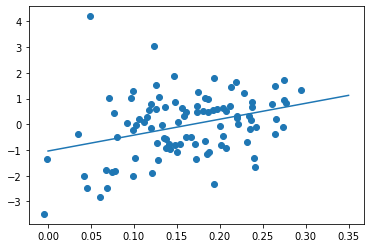

In [59]:
lr = LinearRegression()
lr.fit(x.reshape(-1,1),y.reshape(-1,1))
ls = np.linspace(0,0.35,100).reshape(-1,1)
pred = lr.predict(ls)
plt.plot(ls,pred)
plt.scatter(all_grouped['predicted_label'],all_grouped['change']);

In [100]:
import statsmodels.api as sm
mod = sm.OLS(y,x)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

x1    0.349613
Name: P>|t|, dtype: float64

In [69]:
all_grouped['predicted_label'][d]

IndexError: ignored

In [72]:
init = 1
cor = 0
for d in merged.index:
    if lr.predict(np.array(all_grouped['predicted_label'][d]).reshape(-1,1)) > 0:
        init *= (1+all_grouped['change'][d]/100)
        if all_grouped['change'][d]>0:
            cor+=1
    else:
        init *= (1-all_grouped['change'][d]/100)
        if all_grouped['change'][d]<0:
            cor+=1
print('Final account value:',init)

Final account value: 1.1542867697771504


In [73]:
accuracy = cor/len(merged)
accuracy

0.6521739130434783

In [74]:
init = 1
for d in merged.index:
    init *= (1+all_grouped['change'][d]/100)
init

0.9563284116886498